In [361]:
import tensorflow as tf
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as skmse
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os 
import mtcnn

In [362]:
# cv2 can't directly display image in 'jupyter' IDE. Hence, this function to bypass the same by using cv2 and matplotlib.
def jup_imageshow(path):
    image_path = path # Read the image path
    image = cv2.imread(image_path) # Read the image
    if image is None:
        print("wrong credentials for the image path")
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # change format from cv2 to matplotlib 
        #plt.figure(figsize=(8,6))
        plt.imshow(image_rgb)
        plt.title("Loaded Image")
        plt.axis('off')  # Hide axis
        plt.show()

In [363]:
# jup_imageshow(r"D:\preetam\AIML_Data\Eye detection\Dataset\train\images\i_1_jpg.rf.9ab2cf6915e1be9a55d8a9c560d323d6.jpg")

In [364]:
# funtion to return, name of folders/name of files/number of folders/number of files in a given location in my computer.
def filfol(folder_path,choice):
    items=os.listdir(folder_path)
    # Separate files and folders
    files=[f for f in items if os.path.isfile(os.path.join(folder_path, f))]
    folders=[f for f in items if os.path.isdir(os.path.join(folder_path, f))]
    if choice=="folder": # name of  folders
        return folders
    elif choice=="file": # name of files
        return files
    elif choice=="folder_n": # number of folders
        return len(folders)
    elif choice=="file_n": # number of files
        return len(files)
    else:
        print("wrong input choice")

In [365]:
f_path="D:/preetam/AIML_Data/celebrity/Celebrity only Faces" # MTCNN extracted onlt faces (from main dataset folder) path
print(filfol(f_path,"folder"))
print("Number of folders=", filfol(f_path,"folder_n"))

['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']
Number of folders= 17


In [366]:
y_index=np.arange(17)
y_dict=dict(zip(filfol(f_path,"folder"),y_index))
#print(y_dict["Brad Pitt"])

In [367]:
x=[]
y_label=[]
y=[]
hmax=0 # max pixels along heigt axis
wmax=0 # max pixels along width axis
total_files=0
for f in filfol(f_path,"folder"):
    for fi in filfol(f_path+"/"+f,"file"):
        img_path = os.path.join(f_path+"/"+f, fi)
        img=cv2.imread(img_path)
        img=cv2.resize(img,(100,100)) # resizing all images into similar dimension
        x.append(img)
        y_label.append(f)
        y.append(y_dict[f])
        if img.shape[:2][0]>hmax:
            hmax=img.shape[:2][0]
        if img.shape[:2][1]>wmax:
            wmax=img.shape[:2][0]
    #print(filfol(f_path+"/"+f,"file_n"))
    #total_files=total_files+filfol(f_path+"/"+f,"file_n")
#print(total_files)

In [368]:
x=np.array(x)
y=np.array(y)

In [369]:
# print an image
'''plt.rcParams["figure.figsize"] = (4, 4)
plt.imshow(cv2.cvtColor(x[100], cv2.COLOR_BGR2RGB))
plt.show()'''

'plt.rcParams["figure.figsize"] = (4, 4)\nplt.imshow(cv2.cvtColor(x[100], cv2.COLOR_BGR2RGB))\nplt.show()'

In [370]:
# Train/test dataset split
x=x/255
xtrain, xtest, ytrain, ytest=train_test_split(x,y,test_size=0.2, shuffle=True, random_state=42)

In [371]:
    # Data augmentation pipeline #

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),                # Mirror faces left/right
    #tf.keras.layers.RandomRotation(0.02),                    # ~ ±7.2° rotation
    tf.keras.layers.RandomTranslation(0.1, 0.1),             # Shift up to 10% in x/y
    tf.keras.layers.RandomZoom(0.10),                         # Zoom in/out by 10%
    #tf.keras.layers.RandomBrightness(factor=0.1),            # Adjust brightness ±10%
    tf.keras.layers.RandomContrast(factor=0.1),              # Adjust contrast ±10%
    #tf.keras.layers.RandomCrop(height=90, width=90),         # Slight cropping
])

In [372]:
# CNN Layer description
cnn=tf.keras.models.Sequential([
    # CNN
    data_augmentation,
    #tf.keras.layers.InputLayer(shape=(100, 100, 3)),

    #tf.keras.layers.ZeroPadding2D(padding=1),
    #tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    #tf.keras.layers.ZeroPadding2D(padding=1),
    #tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    #tf.keras.layers.ZeroPadding2D(padding=1),
    #tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    #tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),

    # Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(17, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
])

In [373]:
# Compile the model
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [374]:

# ---------------------------
# Callbacks
# ---------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=5,
    min_lr=1e-6
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_cnn_model.keras',  # saved model filename
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [375]:
# Training the model
history = cnn.fit(
    xtrain, ytrain,
    validation_data=(xtest, ytest),
    epochs=150,
    batch_size=36,
    callbacks=[early_stop, lr_schedule, checkpoint]
)

Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.1079 - loss: 8.5312
Epoch 1: val_loss improved from inf to 6.50690, saving model to best_cnn_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 480ms/step - accuracy: 0.1081 - loss: 8.4845 - val_accuracy: 0.0461 - val_loss: 6.5069 - learning_rate: 0.0010
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.1533 - loss: 4.5753
Epoch 2: val_loss did not improve from 6.50690
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 416ms/step - accuracy: 0.1532 - loss: 4.5709 - val_accuracy: 0.0432 - val_loss: 6.6857 - learning_rate: 0.0010
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.2160 - loss: 3.7509
Epoch 3: val_loss did not improve from 6.50690
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 351ms/step - accuracy: 0.2156 - loss: 3.7490 - val_accuracy: 0.0432 - val_loss: 7.4663 - learning_rate: 0.0010
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2291 - loss: 3.2727
Epoch 4: val_loss did not improve from 6.50690


In [376]:
# Predict
ypred_c = cnn.predict(xtest)
cnn.evaluate(xtest,ytest)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9115 - loss: 0.4526


[0.4517729878425598, 0.910662829875946]

In [377]:
from sklearn.metrics import classification_report
print(classification_report(ytest, np.argmax(ypred_c, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.94      0.89      0.91        18
           2       0.83      0.90      0.86        21
           3       0.93      1.00      0.96        25
           4       0.91      0.84      0.88        25
           5       0.92      0.88      0.90        25
           6       0.79      0.88      0.83        17
           7       1.00      0.90      0.95        20
           8       1.00      1.00      1.00        13
           9       0.88      0.82      0.85        17
          10       1.00      0.88      0.93        16
          11       0.94      0.89      0.92        19
          12       0.96      0.92      0.94        25
          13       0.88      0.97      0.92        31
          14       0.91      1.00      0.95        20
          15       1.00      0.93      0.97        15
          16       0.79      0.86      0.83        22

    accuracy              

In [378]:
cnn.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_36 (Sequential)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 17)             │         4,369 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,260,853 (31.51 MB)

 Trainable params: 2,753,297 (10.50 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 5,506,596 (21.01 MB)

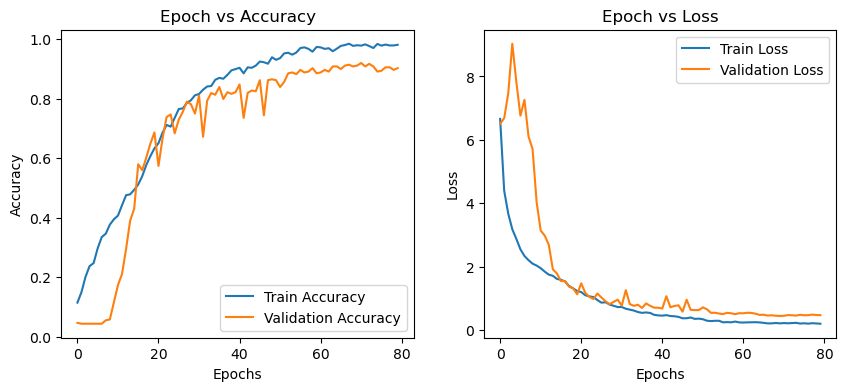

In [379]:
plt.rcParams["figure.figsize"] = (10, 4)

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

In [380]:
import winsound
winsound.Beep(240,2000)